# Multi-armed bandits


* ETC and experiments
* UCB and experiments

## Bulding a simulator for the bandit

In [41]:
from matplotlib import pyplot as plt
import numpy as np  # we can use this library for working with matrices

In [121]:
class Bandit:
    def __init__(self, k, means, rounds):
        # we assume Gaussian distributions with sigma=1
        self.k = k  # number of arms
        self.means = means
        self.rounds = rounds  # number of available rounds
        
        # chose the optimal reward
        self.optimal_reward = max(self.means)
        self.counter = 0
        # gather the empirical regret so far
        self.empirical_regret = 0
        self.emp_regrets = []
        # gather the expected regret so far
        self.expected_regret = 0
        self.exp_regrets = []
    
    def play_arm(self, arm):
        #sample the appropriate reward
        reward = np.random.normal(self.means[arm],1)
        #calculate the regret so far and save it
        self.empirical_regret += self.optimal_reward - reward
        self.expected_regret += self.optimal_reward - self.means[arm]
        self.emp_regrets.append(self.empirical_regret)
        self.exp_regrets.append(self.expected_regret)
        self.counter = self.counter+1
        
        return reward
    
    def finished(self):
        # return if there is no more round remained
        self.counter > self.rounds
        return 
     
    def plot_regret(self):
        plt.plot(list(range(self.counter)), self.emp_regrets, 'b+', list(range(self.counter)), self.exp_regrets, 'ro')
        plt.xlabel("iteration")
        plt.ylabel("regret")
        plt.show()

## ETC algorithm

In [43]:
class ETCsolver:
    def __init__(self, k, m, bandit):
        self.k = k  # number of arms
        self.m = m  # number of exploration rounds for each arm
        self.bandit = bandit
        
        # create a cache storing the number of trials and the average rewards
        # for each action
        self.cache = np.zeros((k,2))
    
    def _exploration_phase(self):
        counter = 0
        while counter < self.k * self.m:
            
            # play the bandit and update cache
            #playing with bandit
            selected_arm = counter % self.k #arm selection
            reward = self.bandit.play_arm(selected_arm)#playing the selected arm
            #updating the cache
            self.cache[selected_arm, 1] = self.cache[selected_arm, 1] + reward#updating the reward value
            self.cache[selected_arm, 0] = self.cache[selected_arm, 0] + 1#updating the trials
            counter = counter + 1
    
    def _choose_best_action(self):
        #we calculate the average reward of each arm
        # returning the best arm
        average_reward = self.cache[:, 1]/self.cache[:, 0]#calc avg
        best_arm = np.argmax(average_reward)#best arm


        return best_arm
    
    def run(self):
        self._exploration_phase()
        optimal_arm = self._choose_best_action()
        # ----- play until finished -----
        while self.bandit.counter < self.bandit.rounds:
            self.bandit.play_arm(optimal_arm)#optimal arm find
        
    
    def get_regret(self):
        return self.bandit.regrets
    
    def best_action(self):
        return self._choose_best_action() + 1

In [44]:
def experiment_etc(k, mu, m, rounds):
    bandit = Bandit(k, mu, rounds)
    etc = ETCsolver(k, m, bandit)

    etc.run()
    etc.bandit.plot_regret()
    print("Optimal action: {}".format(etc.best_action()))

## UCB algorithm

In [45]:
class UCBsolver:
    def __init__(self, k, delta, bandit):
        self.k = k  # number of actions
        self.delta = delta  # error probability
        self.bandit = bandit

        self.cache = np.zeros((k, 2))#storing rewards
        self.actions = []
    
    def _init_phase(self):
        # at the very beginning each arm is equally good
        # unexplored arms are always the best
        #pick each arm once to initialize the cache 
        # we want to avoid division by zero
        for arm in range(self.k):
          reward = self.bandit.optimal_reward#opt reward

          self.cache[arm, 0] = self.cache[arm,0]+1#arm counter
          self.cache[arm,1]=self.cache[arm,1]+reward#reward calc
    
    
    def _choose_best_action(self):
        # this implements the score for ucb
        #first is the average reward term
        #second is the exploration term
        ucb_actions = []
        for arm in range(self.k):
            avg_rwd_term = (self.cache[arm,1])/(self.cache[arm,0])#avg rwd
            explore_term = np.sqrt((2*np.log(1/self.delta))/(self.cache[arm,0]))#explor term
            sum_ = avg_rwd_term + explore_term#the algo value
            ucb_actions.append(sum_)#adding to list
        best_arm = ucb_actions.index(max(ucb_actions))
        return best_arm

    
    def run(self):
        self._init_phase()

        while self.bandit.counter < self.bandit.rounds:

            # chooe optimal arm
            optimal_arm = self._choose_best_action()

            #  storing the actions so far
            self.actions.append(optimal_arm)

            # playing the chosen arm
            optimal_reward = self.bandit.play_arm(optimal_arm)

            # update cache
            self.cache[optimal_arm, 0] = self.cache[optimal_arm, 0] +1
            sum_rwd = self.cache[optimal_arm,1] + optimal_reward
            self.cache[optimal_arm, 1] = sum_rwd
    
    def plot_actions(self):
        plt.plot(list(range(len(self.actions))), self.actions, 'r+')
        plt.xlabel("iteration")
        plt.ylabel("chosen action")
        plt.show()

In [46]:
def experiment_ucb(k, mu, delta, rounds):
    bandit = Bandit(k, mu, rounds)
    ucb = UCBsolver(k, delta, bandit)

    ucb.run()
    ucb.bandit.plot_regret()
    ucb.plot_actions()

## Experiments

### ETC use-cases

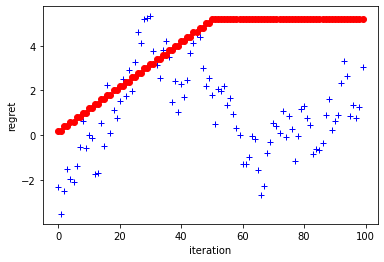

Optimal action: 2


In [94]:
# Try it with two arms and small difference between the mean values
# What are the required number of rounds to find the best action?

experiment_etc(k=2, mu=(1.6, 1.8), m=26, rounds=100)

#when we try lower values of m the algorithm rarely finds out the accurate value for good reward/right policy. Since, there is very low difference between the mean of the two distributions which are in question here because of there is a high amount of overlap between the distributions and when we increase the value of m to a higher number around 20 it more often than not finds the right policy for itself to minimize the regret. The empherical regret also stays quite lower than expected regret, around the value of 20 the empherical regret stagnates easily

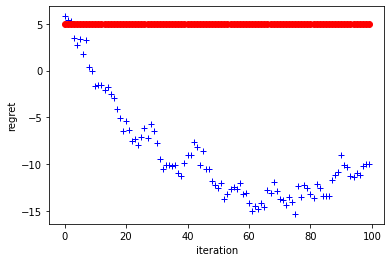

Optimal action: 2


In [125]:
# Try it with two arms and big difference between the mean values
# What are the required number of rounds to find the best action?

experiment_etc(k=2, mu=(10, 15), m=1, rounds=100)
#when the difference is high between the values of mean the algorithm finds the right policy it quite easily with m as low as 1. The empherical regret is also quite low. Expected regret is only 5

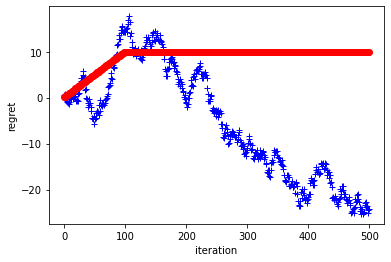

Optimal action: 5


In [49]:
# Try it with five arms and small differences among the mean values
# What are the required number of rounds to find the best action?

experiment_etc(k=5, mu=(1.5,1.55,1.45,1.40,1.6), m=20, rounds=500)
#here we plot around 500 rounds and we can see that the empherical regret is decreasing and with m around 20 the values can be distinguished easily by the algorithm to minimize the regret overall as well.

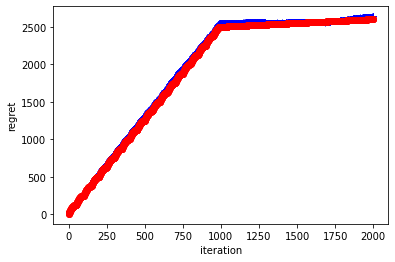

Optimal action: 49


In [138]:
# Try it with fifty arms and small differences among the mean values
# What are the required number of rounds to find the best action?

experiment_etc(k=50, mu=np.linspace(5, 10, num=50, endpoint=True, retstep=False, dtype=None, axis=0), m=20, rounds=2000)
# here we can see that with high number of  distributions cannot be distingished easily between and the and empherical and expected regret as they both follow a similar tragectary and around the value of m =20(trials) we can see the value of empherical and expected regret starts to stagnate with a very high regret.

### UCB use-cases

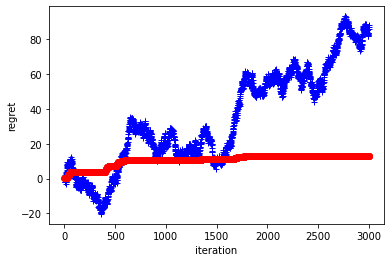

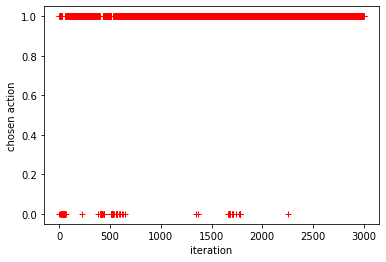

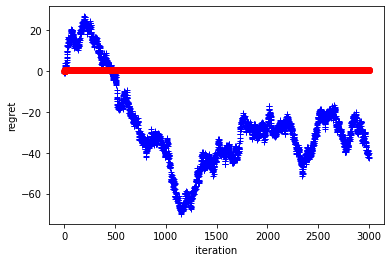

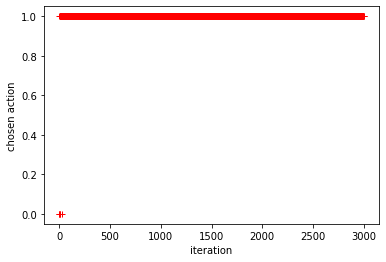

In [114]:
# Try it with two arms and small difference between the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta? 

experiment_ucb(k=2, mu=(0.5,0.6), delta= 0.05, rounds=3000)
experiment_ucb(k=2, mu=(0.5,0.6), delta= 0.9, rounds=3000)
#the number of iterations required to find the best action cannot be defined easily since it depends highly on the value of delta and difference of mean as well. In the plot for expected regret where delta is low it tries for different values even around 2000 interations and when the value of delta is high it doesn't try after 20-30 iterations but, empherical regret is ever increasing
#When delta is low as we can see from first two plots there is a lot of exporation by the algorithm as it  tries both the distributions multiple times. Hence the regret value doesn't stagnate easily in the expected regret.
#when the value of delta is high there is a bit of exploration in the beginning but in the later iterations there is almost none and the regret value stagnates quite quickly in the expected.

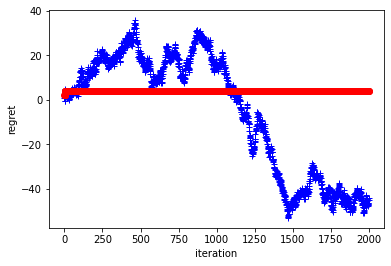

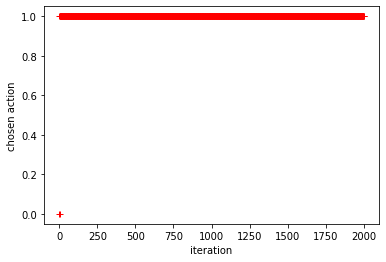

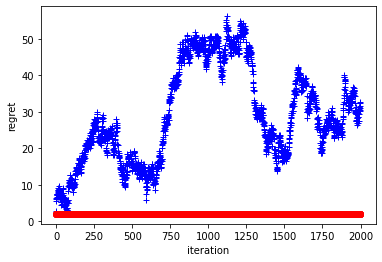

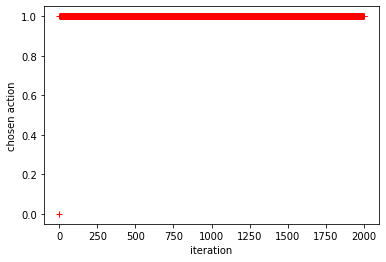

In [118]:
# Try it with two arms and big difference between the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta? 
experiment_ucb(k=2, mu=(5,7), delta= 0.05, rounds=2000)
experiment_ucb(k=2, mu=(5,7), delta= 0.9, rounds=2000)
#the required number of rounds for both delta high and low can be seen here from the plot is not a very high(less than 10) since the expected regret stagnates easily and the empherical regret very low


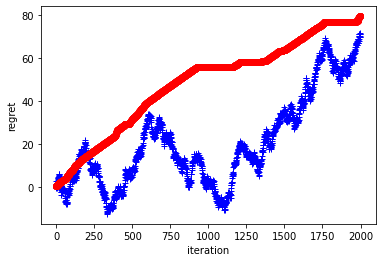

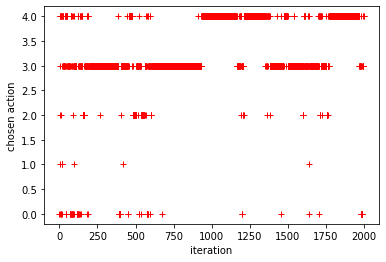

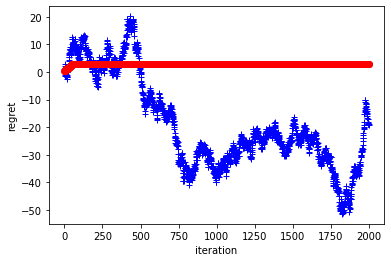

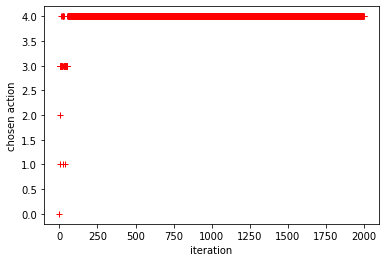

In [145]:
# Try it with five arms and small differences among the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta? 
experiment_ucb(k=5, mu=(0.55,0.60,0.65,0.70,0.75), delta= 0.05, rounds=2000)
experiment_ucb(k=5, mu=(0.55,0.60,0.65,0.70,0.75), delta= 0.9, rounds=2000)
#the number of rounds required for low delta value is very high since it tries multiple values and its still trying around 2000 rounds but for high delta value in empherical the regret falls and in expected as well it doesn't try a lot of values 

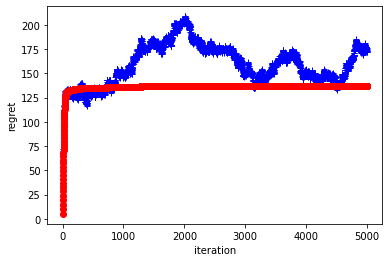

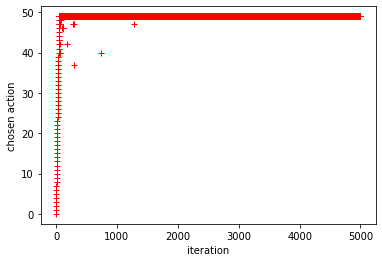

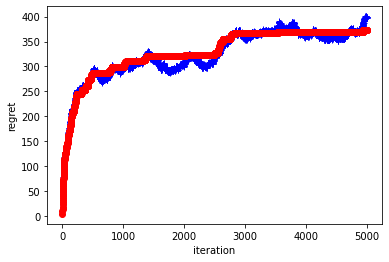

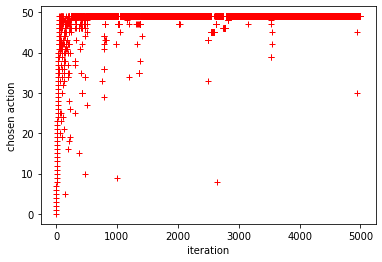

In [146]:
# Try it with fifty arms and small differences among the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta?

experiment_ucb(k=50, mu=np.linspace(5, 10, num=50, endpoint=True, retstep=False, dtype=None, axis=0), delta= 0.9, rounds=5000)
experiment_ucb(k=50, mu=np.linspace(5, 10, num=50, endpoint=True, retstep=False, dtype=None, axis=0), delta= 0.05, rounds=5000)

#the number of values of mu it has is quite high and the algorithm figures out the right value with high delta quickly and sticks with it as we can see with thr first 2 plots but its not the same case with the low delta value as its still trying out new values around 5000 iterations